In [1]:
import pandas as pd
import numpy as np
import sklearn
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from numbers import Number
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, log_loss, roc_curve, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.compose import ColumnTransformer

In [2]:
test = pd.read_csv("../data/test_set_features.csv")
train_feat = pd.read_csv("../data/training_set_features.csv")
train_labels = pd.read_csv("../data/training_set_labels.csv")

In [3]:
train_full = pd.merge(train_feat, train_labels, on='respondent_id', how='inner')
train_full

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,0,0


In [4]:
train_full.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [5]:
train_full = train_full.drop(columns=['respondent_id', 'health_insurance', 'employment_industry',
'employment_occupation'])
train_full

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,0,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,0,0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,0,1
26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,0,0


In [6]:
train_full=train_full.dropna()
train_full

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0
5,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,atmpeygn,"MSA, Principle City",2.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26700,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,"> $75,000",Married,Own,Not in Labor Force,lzgpxyit,"MSA, Principle City",1.0,0.0,0,1
26701,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Not in Labor Force,fpwskwrf,"MSA, Principle City",3.0,0.0,0,0
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,0,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,0,0


In [7]:
train_full.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty                  object
marital_status           

In [8]:
train_full.hhs_geo_region

0        oxchjgsf
1        bhuqouqj
3        lrircsnp
4        qufhixun
5        atmpeygn
           ...   
26700    lzgpxyit
26701    fpwskwrf
26702    qufhixun
26703    lzgpxyit
26706    mlyzmhmf
Name: hhs_geo_region, Length: 19642, dtype: object

In [41]:
numeric_col = ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance',
               'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 
               'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 
               'child_under_6_months', 'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
               'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
               'opinion_seas_sick_from_vacc', 'household_adults', 'household_children'
]

cat_col = [
    'age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 
    'employment_status', 'census_msa'
]

Lol wut

In [42]:
numeric_df = train_full[numeric_col]
X = numeric_df.extend(cat_col)
y = train_full["h1n1_vaccine"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [73]:
X_train.columns

TypeError: 'Index' object is not callable

### Dummy Model

In [43]:
# Dummy: always chooses majority
y.value_counts(normalize=True)

0    0.770186
1    0.229814
Name: h1n1_vaccine, dtype: float64

In [44]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [45]:
# Fit dummy model onto our data
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [46]:
# grabbing first 100 predictions
dummy_model.predict(X_train)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [47]:
y_train.value_counts(normalize=True)

0    0.768787
1    0.231213
Name: h1n1_vaccine, dtype: float64

In [48]:
dummy_model.score(X_train, y_train)

0.7687869119543819

Model is ~76.9% accurate. Neat.

In [49]:
cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)
cv_results.mean()

0.76878692612253

CV Results for `dummy` model:
            0.76879 ± 0.00032 accuracy
        


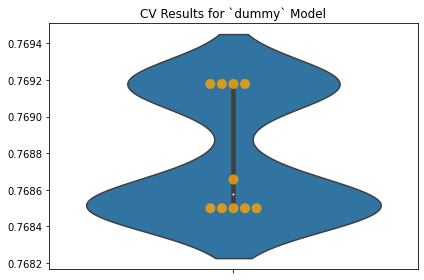

In [50]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax
    
dummy_model_results = ModelWithCV(
                        model=dummy_model,
                        model_name='dummy',
                        X=X_train, 
                        y=y_train
)

fig, ax = plt.subplots()

ax = dummy_model_results.plot_cv(ax)
plt.tight_layout();

dummy_model_results.print_cv_summary()

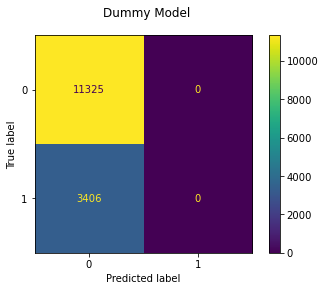

In [51]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

ConfusionMatrixDisplay(confusion_matrix(y_train, dummy_model.predict(X_train))).plot(ax=ax);

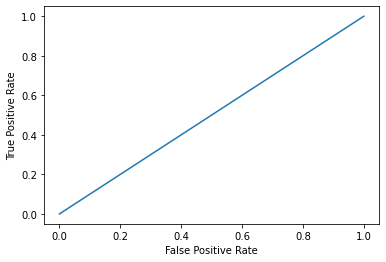

In [52]:
fpr, tpr, thresholds = roc_curve(y_train, dummy_model.predict_proba(X_train)[:,1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot();

In [53]:
dummy_model.predict_proba(X_train)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [54]:
X_train.shape, X_test.shape

((14731, 22), (4911, 22))

In [55]:
y_train.shape, y_test.shape

((14731,), (4911,))

In [56]:
tree_nodepth = DecisionTreeClassifier(random_state=42)
tree_depth = DecisionTreeClassifier(random_state=42, max_depth=2)
tree_nodepth.fit(X_train, y_train)
tree_depth.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

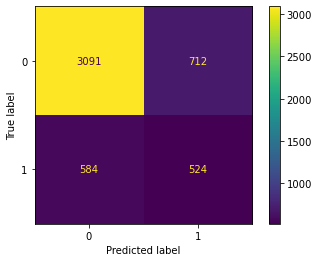

In [57]:
ConfusionMatrixDisplay(confusion_matrix(y_test, tree_nodepth.predict(X_test))).plot()

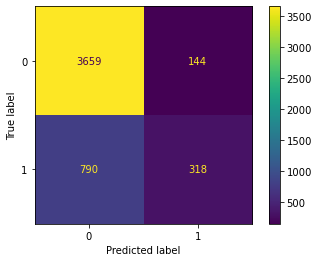

In [58]:
ConfusionMatrixDisplay(confusion_matrix(y_test, tree_depth.predict(X_test))).plot()

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_nodepth, ax=ax);

Horrifying.

In [59]:
y_pred = tree_nodepth.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [60]:
accuracy_score(y_test, y_pred)

0.7361026267562615

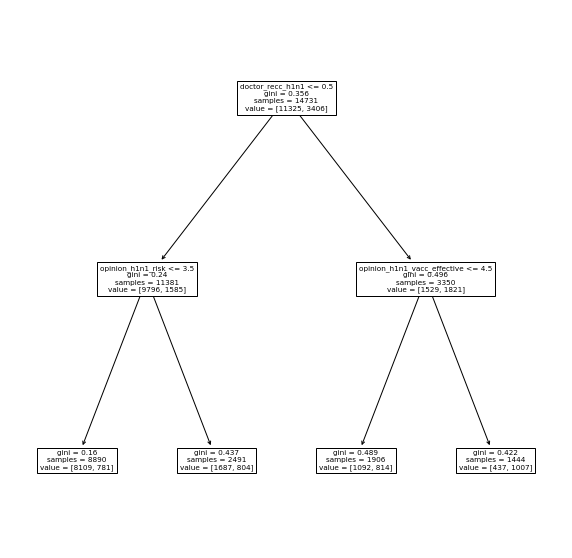

In [61]:
feature_used = X.columns.values
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_depth, ax=ax, feature_names=feature_used);

In [62]:
y_pred_depth = tree_depth.predict(X_test)
y_pred_depth

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [63]:
accuracy_score(y_test, y_pred_depth)

0.8098147016900835

In [64]:
feature_used

array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'behavioral_outside_home', 'behavioral_touch_face',
       'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc',
       'household_adults', 'household_children'], dtype=object)

In [65]:
numeric_df.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
household_adults               0
household_children             0
dtype: int64

In [66]:
cat_df = train_full[cat_col]
cat_df

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,Non-MSA
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,"MSA, Not Principle City"
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,"MSA, Principle City"
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City"
5,65+ Years,12 Years,White,Male,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Principle City"
...,...,...,...,...,...,...,...,...,...
26700,55 - 64 Years,12 Years,White,Female,"> $75,000",Married,Own,Not in Labor Force,"MSA, Principle City"
26701,18 - 34 Years,College Graduate,White,Female,"> $75,000",Not Married,Rent,Not in Labor Force,"MSA, Principle City"
26702,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,Non-MSA
26703,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,"MSA, Principle City"


In [67]:
# Imputers
num_imput = SimpleImputer(add_indicator=True)
cat_imput = SimpleImputer(strategy='constant', fill_value='Unknown', add_indicator=True)

# Pipelines
num_pipeline = Pipeline(steps=[('impute_num', num_imput)])
cat_pipeline = Pipeline(steps=[('impute_cat', cat_imput),
                               ('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [68]:
X_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
8345,2.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,4.0,2.0,2.0,4.0,2.0,5.0,0.0,0.0
25159,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2.0,2.0,4.0,4.0,2.0,1.0,1.0,3.0
21778,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,2.0,2.0,4.0,3.0,2.0,1.0,0.0
628,3.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,5.0,4.0,2.0,5.0,4.0,4.0,1.0,2.0
13176,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,2.0,2.0,2.0,4.0,2.0,1.0,1.0,0.0


In [69]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14731 entries, 8345 to 21501
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 14731 non-null  float64
 1   h1n1_knowledge               14731 non-null  float64
 2   behavioral_antiviral_meds    14731 non-null  float64
 3   behavioral_avoidance         14731 non-null  float64
 4   behavioral_face_mask         14731 non-null  float64
 5   behavioral_wash_hands        14731 non-null  float64
 6   behavioral_large_gatherings  14731 non-null  float64
 7   behavioral_outside_home      14731 non-null  float64
 8   behavioral_touch_face        14731 non-null  float64
 9   doctor_recc_h1n1             14731 non-null  float64
 10  doctor_recc_seasonal         14731 non-null  float64
 11  chronic_med_condition        14731 non-null  float64
 12  child_under_6_months         14731 non-null  float64
 13  health_worker

In [70]:
col_tr = ColumnTransformer(transformers=[('num', num_pipeline, numeric_col),
                                        ('cat', cat_pipeline, cat_col)],
                          remainder='passthrough', sparse_threshold=0)

In [71]:
col_tr.fit_transform(X_train)

ValueError: A given column is not a column of the dataframe